In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm, tqdm_notebook
from lvreml import data_prep
from lvreml import lvreml
from lvreml import initial_screen
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt

In [2]:
# Expression Data
expr_file = '/home/ammar/Documents/YeastFiles/SI_Data_01_expressionValues.txt'
df_expr = pd.read_table(expr_file)
print('Expression Data Shape',df_expr.shape)

# Genotype Data
geno_file = '/home/ammar/Documents/YeastFiles/genotypes_binary_strongest_eqtl.csv'
df_geno = pd.read_csv(geno_file, index_col=0)
print('Genotype Data Shape',df_geno.shape)

# Covariates Data
cov_file = '/home/ammar/Documents/YeastFiles/SI_Data_02_covariates.xlsx'
df_cov = pd.read_excel(cov_file)
print('Covariates Data Shape',df_cov.shape)

Expression Data Shape (1012, 5720)
Genotype Data Shape (1012, 2884)
Covariates Data Shape (1012, 3)


In [3]:
cov = df_cov.values[:,1:3].astype(float) # covariates 
data_expr = df_expr.values.astype(float) # expression values
expr_corr = np.empty_like(data_expr) # empty matrix for corrected expression values

X = pd.DataFrame(cov, columns=['Batch','OD'])
for i in tqdm(range(data_expr.shape[1])):
    y = pd.DataFrame(data_expr[:,i], columns=['expr'])
    df = pd.concat([X,y],axis=1)
    reg = smf.ols(formula="expr ~ OD + C(Batch)", data=df).fit()
    expr_corr[:,i] = reg.resid

100%|██████████| 5720/5720 [01:06<00:00, 85.43it/s]


In [4]:
Zall = df_geno.values.copy()
Y = expr_corr.copy()

print(Zall.shape)
print(Y.shape)

(1012, 2884)
(1012, 5720)


In [5]:
C,Znall,Yn = data_prep.data_prep(Y,Zall)

In [6]:
def RhovsHidden(C,Znall,Yn,theta,rho,flagC):
    THET = np.empty((len(theta),len(rho)))
    HID = np.empty((len(theta),len(rho)))
    RHO = np.empty((len(theta),len(rho)))
    Ex,Vx = np.linalg.eigh(C)
    t = np.flip(np.argsort(Ex))
    Vx = Vx[:,t]
    
    
    for i in range(len(theta)):
        beta2,varexpl,idx = initial_screen.initial_screen(C,Znall,theta[i])
        if flagC == False:
            Z = Znall[:,idx]
        else:
            Z = Vx[:,0:theta[i]]
    
        for j in range(len(rho)):
            X,_,_,_,_,_ = lvreml.lvreml(C,Z,rho[j])
            HID[i,j] = X.shape[1]
            THET[i,j] = theta[i]
            RHO[i,j] = rho[j]

    df1 = pd.DataFrame(THET.flatten()) 
    df2 = pd.DataFrame(HID.flatten())
    df3 = pd.DataFrame(np.round(RHO,3).flatten())
    df = pd.concat([df1, df2,df3], axis=1)
    fig, ax = plt.subplots(figsize=(25,15))
    labels = [x + '-known' for x in theta.astype(str)]
    sns.set(style="whitegrid")
    df.columns = ['theta','hidden','rho']
    ax = sns.barplot(x='rho', y='hidden', hue='theta', data=df)
    ax.tick_params(axis='both',labelsize='20')
    ax.xaxis.label.set_fontsize(25)
    ax.yaxis.label.set_fontsize(25)
    ax.set_title('No. of Hidden Confounders vs RHO', fontsize=25)
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels, fontsize=20)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.minorticks_on()

No covariates to be selected
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no co

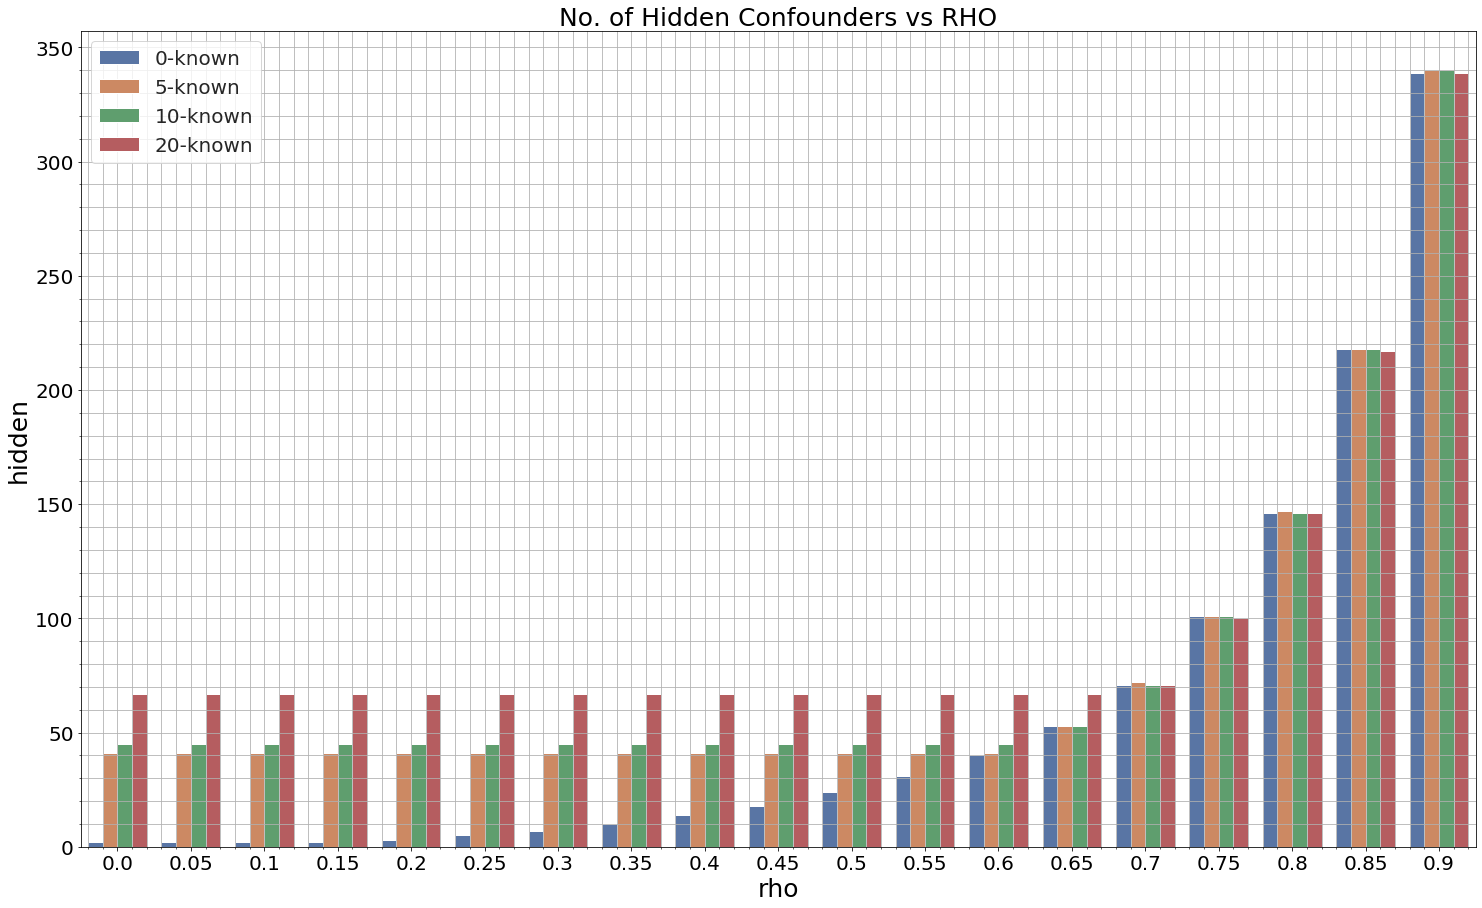

In [7]:
theta =  np.array([0,5,10,20]) # No. of known factors
#theta = np.array([5])
"""  Plot No. of inferred Hidden factors(SNPs) selected with respect to rho values """
rho = np.arange(0.0,0.95,0.05)
RhovsHidden(C,Znall,Yn,theta,rho,flagC=False)

In [8]:
def VariancePlot(C,Znall):
    fig, ax = plt.subplots(figsize=(10,6))
    ns,nc = Znall.shape # no. of covariates and samples
    beta2 = np.zeros((nc,),dtype=float)
    for k in range(nc):
        beta2[k] = (ns*(np.dot(np.dot(Znall[:,k].T,C),Znall[:,k]))/(ns-1)) - (np.trace(C)/(ns-1))
    varexpl = beta2/np.trace(C)
    plt.grid(True)
    plt.xlabel('Variance Explained',fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    sns.distplot(varexpl)

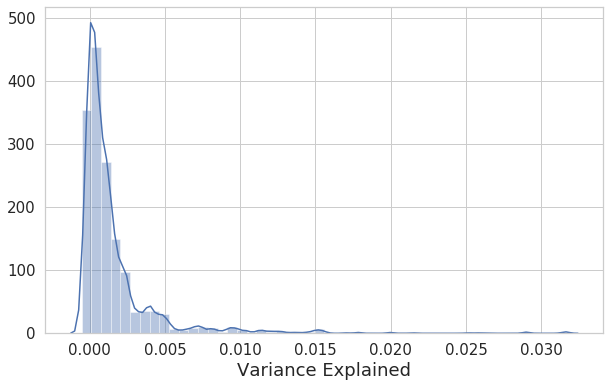

In [9]:
VariancePlot(C,Znall)

In [10]:
def Likelihoodplots(C,Znall,Yn,theta,rho, flagC):
    THET = np.empty((len(theta),len(rho)))
    LL = np.empty((len(theta),len(rho)))
    HID = np.empty((len(theta),len(rho)))
    RHO = np.empty((len(theta),len(rho)))
    Ex,Vx = np.linalg.eigh(C)
    t = np.flip(np.argsort(Ex))
    Vx = Vx[:,t]
    plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    col = ['-bo','--rx','-.ks',':go']
    
    for i in range(len(theta)):
        beta2,varexpl,idx = initial_screen.initial_screen(C,Znall,theta[i])
        if flagC == False:
            Z = Znall[:,idx]
        else:
            Z = Vx[:,0:theta[i]]

        for j in range(len(rho)):
            X,alpha2,B,D,sigma2,K = lvreml.lvreml(C,Z,rho[j])   
            D, V = np.linalg.eigh(K)
            Dinv = np.diag(1/D)
            t1 = np.sum(np.log(D))
            t2 = np.trace(np.dot(np.dot(np.dot(V,Dinv),V.T),C))
            LL[i,j] = -(t1+t2)
            HID[i,j] = X.shape[1]
            THET[i,j] = theta[i]
            RHO[i,j] = rho[j]
        plt.plot(HID[i,:],LL[i,:],col[i])
    
    labels = [x + '-known' for x in theta.astype(str)]    
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.minorticks_on()
    plt.ylabel('Log-likelihood value',fontsize=18)
    plt.xlabel('No. of Hidden confounders',fontsize=18)
    plt.xticks(rho,fontsize=10)
    plt.yticks(fontsize=15)
    plt.legend(labels, fontsize=15)

No covariates to be selected
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
Finding best 5 linearly independent covariates
Inferring desired number of latent variables: 5
Inferring desired number of latent variables: 15

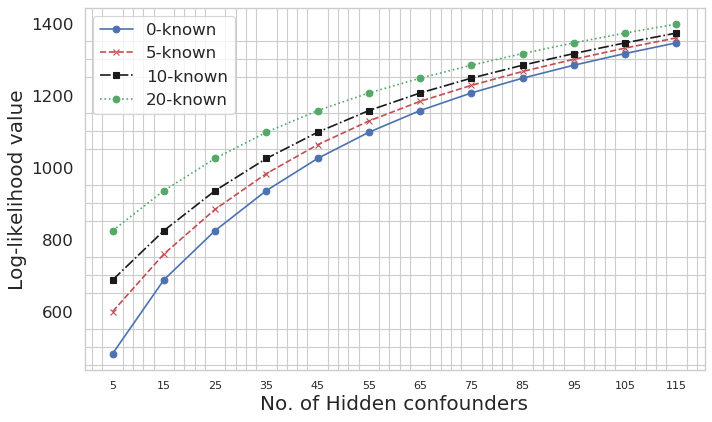

In [11]:
rho = np.arange(5,120,10) # No. of hidden factors
Likelihoodplots(C,Znall,Yn,theta,rho,flagC=True)

In [14]:
def SNPvsTheta(C,Znall,theta):
    sel = np.empty(len(theta))
    for i in range(len(theta)):
        beta2,varexpl,idx = initial_screen.initial_screen(C,Znall,theta[i])
        sel[i] = len(idx)

    plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(theta,sel,'-bo')
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.minorticks_on()
    plt.ylabel('No. of SNPs Selected',fontsize=18)
    plt.xlabel('Theta',fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

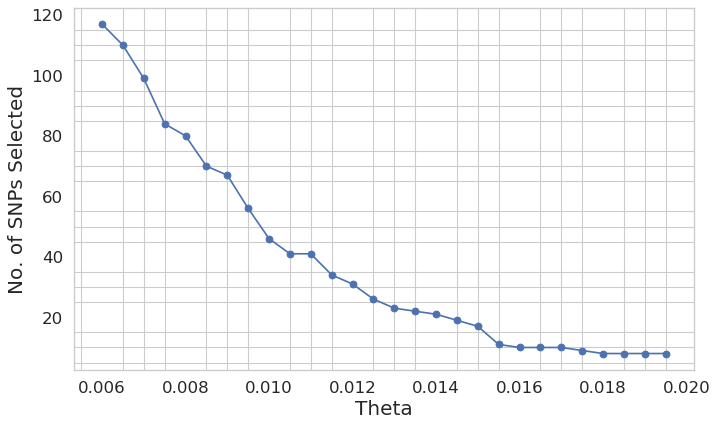

In [15]:
SNPvsTheta(C,Znall,np.arange(0.006,0.02,0.0005))